In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

# Scikit-Learn
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Data Encoding and Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Natural Language Processing(NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Word Embedding
import gensim
from gensim.models import Word2Vec

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
df = pd.read_csv('IntervieweeDataset.csv')

In [5]:
df.shape

(21256, 52)

In [6]:
df.columns

Index(['Name', 'Age', 'Gender', 'Type of Graduation/Post Graduation',
       'Marital status', 'Mode of interview given by candidate?',
       'Pre Interview Check', 'Fluency in English based on introduction',
       'Confidence based on Introduction (English)',
       'Confidence based on the topic given  ',
       'Confidence Based on the PPT Question',
       'Confidence based on the sales scenario',
       'Structured Thinking (In regional only)',
       'Structured Thinking Based on the PPT Question',
       'Structured Thinking( Call pitch)',
       'Regional fluency based on the topic given  ',
       'Regional fluency Based on the PPT Question',
       'Regional fluency based on the  sales scenario',
       'Does the candidate has mother tongue influence while speaking english.',
       'Has acquaintance in Company and has spoken to him/her before applying?',
       'Candidate Status', 'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience 

In [7]:
df.dropna(inplace=True)

In [8]:
df['Experienced Candidate (Nature of work)'].unique()

array(['tech', 'Fresher(<6 months)', 'Sales numbers', ...,
       'Sales numbers, HOTEL MANAGEMENT', 'weekly targets', 'networking'],
      dtype=object)

In [9]:
df['Experienced Candidate (Nature of work)'].value_counts()

Experienced Candidate (Nature of work)
Fresher(<6 months)              12070
Sales numbers                    1946
working hours                     749
Call time                         286
Customer visits                   170
                                ...  
PROJECT EVALUVATION                 1
cctv operator                       1
Emails &Drafting                    1
R&D- to prepare formulation         1
networking                          1
Name: count, Length: 1639, dtype: int64

In [10]:
df.drop(df.iloc[:, 8:18], axis=1, inplace=True)

In [11]:
df.columns

Index(['Name', 'Age', 'Gender', 'Type of Graduation/Post Graduation',
       'Marital status', 'Mode of interview given by candidate?',
       'Pre Interview Check', 'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Has acquaintance in Company and has spoken to him/her before applying?',
       'Candidate Status', 'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'Experienced Candidate (Nature of work)',
       'What was the type of Role?\t',
       'How many slides candidate have submitted in PPT?',
       'Call-pitch Elements used during the call Sales Scenario',
       'But, my child's exam are going on now, so we will keep the counselling session after the exams get over.(Time: Favourable pitch: Counsellor hype)',
       'Let me discuss it with my child',
       'Sir being in education industry I know this is a marketing gimmick and at th

In [12]:
df.drop(['Name',
        'Pre Interview Check',
         'Experienced Candidate (Nature of work)',
         'Call-pitch Elements used during the call Sales Scenario',
         "But, my child's exam are going on now, so we will keep the counselling session after the exams get over.(Time: Favourable pitch: Counsellor hype)",
         'Let me discuss it with my child',
         "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app.",
         'Comments',
         'RedFlags Comments in Interview',
         'Whether joined the company or not\n',
         'Role Location to be given to the candidate'
        ], axis=1, inplace=True)

In [13]:
df.columns = df.columns.str.removesuffix(" .1")
df.columns = df.columns.str.removesuffix(".1")

In [14]:
df.columns

Index(['Age', 'Gender', 'Type of Graduation/Post Graduation', 'Marital status',
       'Mode of interview given by candidate?',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Has acquaintance in Company and has spoken to him/her before applying?',
       'Candidate Status', 'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?\t',
       'How many slides candidate have submitted in PPT?', 'Role acceptance',
       'Interview Verdict', 'Candidate is willing to relocate',
       'Confidence based on Introduction (English)',
       'Confidence based on the topic given ',
       'Confidence Based on the PPT Question',
       'Confidence based on the sales scenario',
       'Structured Thinking (In regional only)',
       'Structured Thinking Based on the PPT Question',
       'Structured Thinking( Call pitch)',
 

## Renamed Columns

In [16]:
df.rename(columns={'What was the type of Role?\t': 'What was the type of Role?'}, inplace=True)

In [17]:
df.rename(columns = {'Has acquaintance in Company and has spoken to him/her before applying?' : 'Acquaintance and Referral'}, inplace=True)
df.rename(columns = {'Type of Graduation/Post Graduation' : 'Education'}, inplace=True)
df.rename(columns= {'Mode of interview given by candidate?' : 'Mode of Interview'}, inplace=True)

In [18]:
df['id'] = df.index

In [19]:
df.columns

Index(['Age', 'Gender', 'Education', 'Marital status', 'Mode of Interview',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Acquaintance and Referral', 'Candidate Status',
       'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?',
       'How many slides candidate have submitted in PPT?', 'Role acceptance',
       'Interview Verdict', 'Candidate is willing to relocate',
       'Confidence based on Introduction (English)',
       'Confidence based on the topic given ',
       'Confidence Based on the PPT Question',
       'Confidence based on the sales scenario',
       'Structured Thinking (In regional only)',
       'Structured Thinking Based on the PPT Question',
       'Structured Thinking( Call pitch)',
       'Regional fluency based on the topic given ',
       'Regional fluency Based on the PPT Quest

In [20]:
education_mapping = {
    'Engineering & Technology': [
        'B.E / B-Tech', 'M.E / M-Tech', 'B-Tech - INTEGRATED', 'BE - CSe and CDAC',
        'B.ENG', 'Bachelors of planning', 'B.Arch', 'Bachelor of Architecture', 'B.ARC'
    ],
    'Science & Medical': [
        'BSc or MSc', 'BSC', 'MS', 'Masters in biotechnology', 'PG - msc biochemistry',
        'Bio science', 'masters in biology', 'biotech', 'Masters of Statistics',
        'Bachelors in biotechnology', 'Ph D genetics', 'MBBS', 'Bachelor in medical lab',
        'B.Physiotherapist', 'B.pharma', 'M.pharma', 'B -pharm', 'B.PHARMA',
        'PHARMA D', 'pharm D', 'M.Pharma', 'Bachelors in dental',
        'Masters in Clinical Psychology', 'B.voc in applied clinical psychology'
    ],
    'Commerce & Business': [
        'B.com', 'BCOM COMPUTERS', 'Bcom computers', 'bcom -pa', 'M.com',
        'MBA', 'MBA- 2019', 'MBA agro business', 'PGDM', 'pgdm', 'PGDM 2022',
        'PGDM marketing', 'PG diploma in banking', 'PG DIPLOMA IN BANKING',
        'Masters in banking and insurance', 'BBA or BBM', 'BBM',
        'Bachelor of Business Economics (B.B.E.)', 'PGPM', 'PGPM in marketing',
        'PGPCEM', 'PGDBS', 'B.Voc - Banking & Finance'
    ],
    'Humanities & Social Sciences': [
        'BA/MA', 'LLB', 'LLM', 'MPhil', 'M.phil', 'Mphil 2020', 'PHD', 'doctorate',
        'Masters of Social Work (MSW)', 'msw', 'msw-hr-2014', 'MSW HRM',
        'Public administration', 'Masters in comparative religion', 'Masters in archeology',
        'English Honors', 'MASTERS IN SOCIAL SCIENCE', 'Bengali Honors'
    ],
    'Mass Communication & Media': [
        'B.comm (Bachelor of mass comm.)', 'Bachelor mass communication',
        'mass media', 'masss media', 'mass comm', 'Mass comm', 'BMM ( MAss Media)',
        'BJMC', 'MJMC 2020', 'Masters in mass communication', 'MASTERS IN MASS COM',
        'Masters in Convergent Journalism', 'master maas comm', 'master in electronic media'
    ],
    'Vocational & Professional Courses': [
        'B.ed (Teaching)', 'B.ed', 'B.ED', 'M.ed', 'D.el.ed', 'd el. ed', 'Dled',
        'Bachelors in fisheries science', 'Bachelors in tourism', 'Bachelor of Tourism',
        'travel & toursim', 'Bachelors in design', 'B.Design', 'Bachelors in hospitality',
        "Bachelor's in Hospitality", 'Hotel Management', 'Masters in fashion designing',
        'Masters in hospitality', 'Masters in design', 'food technology',
        'BVoc', 'B.VOC', 'B.vocational', 'B.voc - IT', 'B.voc networking and mobile applications',
        'bachelors of vocational - automobile', 'Bpharma', 'Mpharma', 'Diploma', 'Diploma in engr',
        'PGDCA', 'PGD', 'pgdca', 'PGD (Bachelor of Library Science)', 'BMIT',
        'PGDF', 'PGDA', 'MFC', 'MLIS', 'BMS', 'BMS marketing', 'bms', 'bms-2020',
        'Bachelor in IT', 'BCA/MCA', 'CSE', 'PDGM Advance Computing'
    ]
}

# Function to map education to categories
def categorize_education(education):
    for category, degrees in education_mapping.items():
        if education in degrees:
            return category
    return 'Other'  # Default category if not found

In [21]:
df['Education'] = df['Education'].apply(categorize_education)

In [22]:
df['Interview Verdict'].unique()

array(['Reject', 'Premium Select', 'Borderline Select', 'Select',
       'Borderline Reject'], dtype=object)

In [23]:
df['Interview Verdict'] = df['Interview Verdict'].replace({'Premium Select':'Select', 'Borderline Select':'Select', 'Borderline Reject':'Reject'})
df['Interview Verdict'].unique()

array(['Reject', 'Select'], dtype=object)

In [24]:
df['Age'] = df['Age'].astype(str).str.replace('+','', regex=False).astype(int)

In [25]:
bins = [18, 22, 25, 28, 32, 35, float('inf')]
labels = ['18-22', '23-25', '26-28', '29-32', '33-35', '35+']

In [26]:
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

In [27]:
df.columns

Index(['Age', 'Gender', 'Education', 'Marital status', 'Mode of Interview',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Acquaintance and Referral', 'Candidate Status',
       'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?',
       'How many slides candidate have submitted in PPT?', 'Role acceptance',
       'Interview Verdict', 'Candidate is willing to relocate',
       'Confidence based on Introduction (English)',
       'Confidence based on the topic given ',
       'Confidence Based on the PPT Question',
       'Confidence based on the sales scenario',
       'Structured Thinking (In regional only)',
       'Structured Thinking Based on the PPT Question',
       'Structured Thinking( Call pitch)',
       'Regional fluency based on the topic given ',
       'Regional fluency Based on the PPT Quest

## Label Encoding

In [29]:
le = LabelEncoder()
le

LabelEncoder()

In [30]:
df['Gender'] = le.fit_transform(df['Gender'])
df['Marital status'] = le.fit_transform(df['Marital status'])
df['Mode of Interview'] = le.fit_transform(df['Mode of Interview'])
df['Does the candidate has mother tongue influence while speaking english.'] = le.fit_transform(df['Does the candidate has mother tongue influence while speaking english.'])
df['Acquaintance and Referral'] = le.fit_transform(df['Acquaintance and Referral'])
df['Currently Employed'] = le.fit_transform(df['Currently Employed'])
df['Candidate is willing to relocate'] = le.fit_transform(df['Candidate is willing to relocate'])
df['Interview Verdict'] = le.fit_transform(df['Interview Verdict'])

## Ordinal and OneHot Encoding using Column Transformer

In [32]:
transformer = ColumnTransformer(transformers = [
    ('t1', OneHotEncoder(sparse_output=False, drop='first'), ['Fluency in English based on introduction', 'Candidate Status', 'Education', 'What was the type of Role?']),
    ('t2', OrdinalEncoder(categories=[['Fresher', '0-1.99', '2-2.99', '3-3.99', '4-4.99', '5-5.99', '6-6.99', '7+']]), ['Last Fixed CTC (lakhs) ']),
    ('t3', OrdinalEncoder(categories=[['Fresher(<6 months)', '6-11.99 Months', '12-17.99 Months', '18-23.99 Months', '24-29.99 Months', '30-35.99 Months', '36-47.99 Months', '48+ Months']]), ['Experienced candidate - (Experience in months)']),
    ('t4', OrdinalEncoder(categories=[['No', 'Yes : Think and says yes.(Shows some hesitation)', 'Emphatic Yes']]), ['Role acceptance']),
    ('t5', OrdinalEncoder(categories=[['18-22', '23-25', '26-28', '29-32', '33-35', '35+']]), ['Age']),
    ('t6', OrdinalEncoder(categories=[['Wrong File/PPT Submitted', 'No slides or Wrong PPT submitted', "Only Name Slide/No Slide Attached (Blank/Template PPT Submitted)", '1 slide', '2 - 3 slides', '4 - 5 slides', '5 - 6 slides', 'More than 6 slides']]), ['How many slides candidate have submitted in PPT?'])
], remainder='passthrough')

In [33]:
df = transformer.fit_transform(df)
features_names = transformer.get_feature_names_out()
df = pd.DataFrame(df, columns=features_names)

In [34]:
df.columns = df.columns.str.replace(r'^remainder__', '', regex=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18681 entries, 0 to 18680
Data columns (total 42 columns):
 #   Column                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                          --------------  -----  
 0   t1__Fluency in English based on introduction_Natural Stutter and Stammer                                                        18681 non-null  float64
 1   t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter  18681 non-null  float64
 2   t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot                               18681 non-null  float64
 3   t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months)                

In [36]:
df.head(2)

,t1__Fluency in English based on introduction_Natural Stutter and Stammer,t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter,t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot,t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months),t1__Candidate Status_Fresher(only 2022 grad),t1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience),t1__Education_Engineering & Technology,t1__Education_Humanities & Social Sciences,t1__Education_Mass Communication & Media,t1__Education_Other,...,Structured Thinking Based on the PPT Question,Structured Thinking( Call pitch),Regional fluency based on the topic given,Regional fluency Based on the PPT Question,Regional fluency based on the sales scenario,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score,id
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,2.0,1.0,1.0,1.0,11.0,7.0,3.0,42.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0,1.0


In [37]:
numerical_df = df[['id','Interview Verdict']]
df.drop(['id','Interview Verdict'], axis=1, inplace=True)

## Feature Scaling

In [39]:
scaler = StandardScaler()
scaler

StandardScaler()

In [40]:
scaled_data = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=scaler.get_feature_names_out())

In [41]:
type(df)

pandas.core.frame.DataFrame

In [42]:
df.head()

,t1__Fluency in English based on introduction_Natural Stutter and Stammer,t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter,t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot,t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months),t1__Candidate Status_Fresher(only 2022 grad),t1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience),t1__Education_Engineering & Technology,t1__Education_Humanities & Social Sciences,t1__Education_Mass Communication & Media,t1__Education_Other,...,Structured Thinking (In regional only),Structured Thinking Based on the PPT Question,Structured Thinking( Call pitch),Regional fluency based on the topic given,Regional fluency Based on the PPT Question,Regional fluency based on the sales scenario,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,3.0,2.0,1.0,1.0,1.0,11.0,7.0,3.0,42.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,1.0,3.0,10.0,9.0,7.0,52.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,2.0,2.0,1.0,3.0,1.0,3.0,10.0,5.0,7.0,44.0


# Principal Component Analysis(PCA) for Dimensionality Reduction
**Required to reduce the number of features**

In [44]:
# pca = PCA(n_components=0.98)
# df = pca.fit_transform(df)

In [45]:
# type(df)

In [46]:
# df = pd.DataFrame(df, columns=pca.get_feature_names_out())

In [47]:
# type(df)

In [48]:
# df.shape

In [49]:
df.head()

,t1__Fluency in English based on introduction_Natural Stutter and Stammer,t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter,t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot,t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months),t1__Candidate Status_Fresher(only 2022 grad),t1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience),t1__Education_Engineering & Technology,t1__Education_Humanities & Social Sciences,t1__Education_Mass Communication & Media,t1__Education_Other,...,Structured Thinking (In regional only),Structured Thinking Based on the PPT Question,Structured Thinking( Call pitch),Regional fluency based on the topic given,Regional fluency Based on the PPT Question,Regional fluency based on the sales scenario,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,3.0,2.0,1.0,1.0,1.0,11.0,7.0,3.0,42.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,1.0,3.0,10.0,9.0,7.0,52.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,2.0,2.0,1.0,3.0,1.0,3.0,10.0,5.0,7.0,44.0


In [50]:
numerical_df.shape

(18681, 2)

In [51]:
df.shape

(18681, 40)

In [52]:
df = df.join(numerical_df, how='inner')

In [53]:
df.shape

(18681, 42)

In [54]:
df['id'] = df['id'].astype(int)
df['Interview Verdict'] = df['Interview Verdict'].astype(int)

In [55]:
df.head()

,t1__Fluency in English based on introduction_Natural Stutter and Stammer,t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter,t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot,t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months),t1__Candidate Status_Fresher(only 2022 grad),t1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience),t1__Education_Engineering & Technology,t1__Education_Humanities & Social Sciences,t1__Education_Mass Communication & Media,t1__Education_Other,...,Structured Thinking( Call pitch),Regional fluency based on the topic given,Regional fluency Based on the PPT Question,Regional fluency based on the sales scenario,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score,id,Interview Verdict
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,1.0,1.0,1.0,11.0,7.0,3.0,42.0,0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0,1,0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,1.0,3.0,10.0,9.0,7.0,52.0,2,1
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0,3,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,1.0,3.0,10.0,5.0,7.0,44.0,4,1


In [56]:
y = df['Interview Verdict']
X = df
X.drop(['Interview Verdict','id'], axis=1, inplace=True)

In [57]:
X.head()

,t1__Fluency in English based on introduction_Natural Stutter and Stammer,t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter,t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot,t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months),t1__Candidate Status_Fresher(only 2022 grad),t1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience),t1__Education_Engineering & Technology,t1__Education_Humanities & Social Sciences,t1__Education_Mass Communication & Media,t1__Education_Other,...,Structured Thinking (In regional only),Structured Thinking Based on the PPT Question,Structured Thinking( Call pitch),Regional fluency based on the topic given,Regional fluency Based on the PPT Question,Regional fluency based on the sales scenario,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,3.0,2.0,1.0,1.0,1.0,11.0,7.0,3.0,42.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,1.0,3.0,10.0,9.0,7.0,52.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,2.0,2.0,1.0,3.0,1.0,3.0,10.0,5.0,7.0,44.0


In [58]:
X.columns.tolist()

['t1__Fluency in English based on introduction_Natural Stutter and Stammer',
 't1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter',
 't1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot',
 't1__Candidate Status_Experienced in non client facing(equal to or more than 6 months)',
 't1__Candidate Status_Fresher(only 2022 grad)',
 't1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience)',
 't1__Education_Engineering & Technology',
 't1__Education_Humanities & Social Sciences',
 't1__Education_Mass Communication & Media',
 't1__Education_Other',
 't1__Education_Science & Medical',
 't1__Education_Vocational & Professional Courses',
 't1__What was the type of Role?_Individual Contributor',
 't1__What was the type of Role?_Team Handling',
 't2__Last Fixed CTC (lakhs) ',
 't3__Experienced candidate - (Experience in months)',
 't4__Role acceptance',

In [59]:
len(X.columns)

40

In [60]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: Interview Verdict, dtype: int32

<hr style="border: 2px dashed yellow;">

## Data Splitting

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')
print(f'Length of y_train: {len(y_train)}')
print(f'Length of y_test: {len(X_test)}')

Length of X_train: 14944
Length of X_test: 3737
Length of y_train: 14944
Length of y_test: 3737


In [65]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [66]:
X_train_index = X_train.index
X_test_index = X_test.index

## Model Training (Using basic ML Models)

In [68]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [69]:
y_pred_rf = model_rf.predict(X_test)
len(y_pred_rf)

3737

In [70]:
# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)*100
print(f"Accuracy is {accuracy_rf:.2f}%")

Accuracy is 87.74%


In [71]:
## Dataset

In [72]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [73]:
class CandidateDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [74]:
train_data = CandidateDataset(X_train_tensor, y_train_tensor)
test_data = CandidateDataset(X_test_tensor, y_test_tensor)

In [75]:
X_train.shape[1]

40

In [76]:
y_train.head()

2791     0
17883    1
5550     1
16824    1
7535     0
Name: Interview Verdict, dtype: int32

## DataLoader

In [78]:
BATCH_SIZE = 16

In [79]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [80]:
len(train_data), len(test_data)

(14944, 3737)

In [81]:
len(train_dataloader), len(test_dataloader)

(934, 234)

## Define a Model

In [83]:
# class HybridRecommender(nn.Module):
#     def __init__(self, input_dim):
#         super(HybridRecommender, self).__init__()
        
#         self.network = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.Dropout(p=0.3),

#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.Dropout(p=0.3),

#             nn.Linear(64, 32),
#             nn.LeakyReLU(negative_slope=0.01),

#             nn.Linear(32, 1),
#             # nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.network(x).squeeze()

In [84]:
class HybridRecommender(nn.Module):
    def __init__(self, input_size, hidden_units):
        super(HybridRecommender, self).__init__()
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(input_size, hidden_units)        # Input layer
        self.fc2 = nn.Linear(hidden_units, hidden_units // 2) # Hidden layer
        self.fc3 = nn.Linear(hidden_units // 2, 1)            # Output layer 

        # Activation Functions & Regularization
        self.dropout = nn.Dropout(0.3)
        self.batchnorm1 = nn.BatchNorm1d(hidden_units)
        self.batchnorm2 = nn.BatchNorm1d(hidden_units // 2)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        # x = self.batchnorm1(x)
        # x = self.dropout(x)

        # x = F.relu(self.fc2(x))
        # x = self.batchnorm2(x)
        # x = self.dropout(x)

        # # x = torch.sigmoid(self.fc3(x)).squeeze()  # Binary Classification Output
        # x = self.fc3(x).squeeze()
        # return x

        x = self.fc1(x)
        x = self.batchnorm1(x)  # Apply BN before activation
        x = F.relu(x)
        x = self.dropout(x)
    
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.dropout(x)
    
        return self.fc3(x).squeeze() 

In [85]:
''' Initializing the model '''
input_size = X_train.shape[1]
hidden_units = 128

model_0 = HybridRecommender(input_size, hidden_units)
# model_0 = HybridRecommender(input_size)
# model_0.to(device)

In [86]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 15

In [87]:
''' Loss Function and Optimizer '''
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

## Training Loop

In [89]:
def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy,
              device:torch.device):

    train_loss, train_acc = 0,0
    model.train()

    for features, labels in dataloader:
        X, y = features.to(device), labels.to(device)
        # Forward Pass
        # y_pred = model(X)
        y_logits = model(X).squeeze()
        # y_pred = torch.round(torch.sigmoid(y_logits))
        y_pred = (y_logits > 0).float()

        # Calculate Loss and Accuracy per batch
        # loss = loss_function(y_pred, y)
        loss = loss_function(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy(y, y_pred).item()*100

        # Set gradients to zero
        optimizer.zero_grad()

        # Back Propogation
        loss.backward()

        # Update the Parameters
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

## Testing Loop

In [91]:
def test_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             accuracy,
             device:torch.device):

    test_loss, test_acc = 0,0

    model.eval()
    with torch.inference_mode():
        for features, labels in dataloader:
            X, y = features.to(device), labels.to(device)
            # Forward Pass
            # test_pred = model(X)
            test_logits = model(X).squeeze()
            # test_pred = torch.round(torch.sigmoid(test_logits))
            test_pred = (test_logits > 0).float()
            
            # Calculate Loss and Accuracy per batch
            loss = loss_function(test_logits, y)
            test_loss += loss.item()
            test_acc += accuracy(y, test_pred).item()*100

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

## Combining Training and Testing Loop into evaluate()

In [93]:
def evaluate(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             optimizer:torch.optim.Optimizer,
             accuracy,
             device:torch.device,
             epochs:int = 5):

    model.to(device)
    # Create empty result dictionary
    results = {'train_loss':[],
              'train_acc':[],
              'test_loss':[],
              'test_acc':[]}

    # Loop through training and testing steps for the number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          optimizer=optimizer,
                                          accuracy=accuracy,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_function=loss_function,
                                          accuracy=accuracy,
                                          device=device)

        print(f'Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%')      

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [94]:
torch.manual_seed(42)
accuracy = Accuracy(task='binary').to(device)

model_0_results = evaluate(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_function=loss_function,
                        optimizer=optimizer,
                        accuracy=accuracy,
                        device=device,
                        epochs=epochs)

Training Loss: 0.36462 | Training Accuracy: 84.09% | Testing Loss: 0.30870 | Testing Accuracy: 87.28%
Training Loss: 0.34059 | Training Accuracy: 85.57% | Testing Loss: 0.30454 | Testing Accuracy: 86.97%
Training Loss: 0.33000 | Training Accuracy: 86.22% | Testing Loss: 0.30754 | Testing Accuracy: 87.69%
Training Loss: 0.32831 | Training Accuracy: 86.01% | Testing Loss: 0.29611 | Testing Accuracy: 87.46%
Training Loss: 0.32435 | Training Accuracy: 86.24% | Testing Loss: 0.30127 | Testing Accuracy: 87.86%
Training Loss: 0.32428 | Training Accuracy: 86.45% | Testing Loss: 0.29480 | Testing Accuracy: 87.21%
Training Loss: 0.32455 | Training Accuracy: 86.04% | Testing Loss: 0.29693 | Testing Accuracy: 87.80%
Training Loss: 0.32127 | Training Accuracy: 86.12% | Testing Loss: 0.29258 | Testing Accuracy: 87.70%
Training Loss: 0.31746 | Training Accuracy: 86.62% | Testing Loss: 0.29452 | Testing Accuracy: 87.56%
Training Loss: 0.31442 | Training Accuracy: 87.02% | Testing Loss: 0.28931 | Testi

## Loss and Accuracy Curves

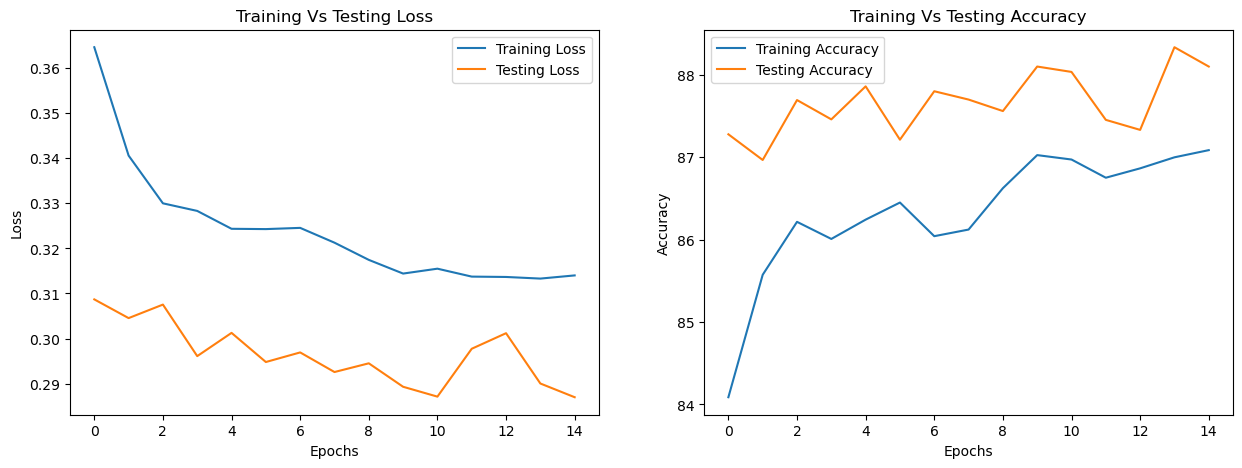

In [96]:
plt.figure(figsize=(15,5))
epochs = range(len(model_0_results['train_loss']))

plt.subplot(1,2,1)
plt.plot(epochs, model_0_results['train_loss'], label='Training Loss')
plt.plot(epochs, model_0_results['test_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Vs Testing Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, model_0_results['train_acc'], label='Training Accuracy')
plt.plot(epochs, model_0_results['test_acc'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Vs Testing Accuracy')
plt.legend()

plt.show()

## Recommending Top 5 Candidates

In [98]:
print(X_test_tensor) 

tensor([[ 0.,  0.,  0.,  ...,  8.,  5., 46.],
        [ 0.,  0.,  0.,  ...,  5.,  4., 32.],
        [ 0.,  1.,  0.,  ...,  6.,  5., 36.],
        ...,
        [ 0.,  0.,  0.,  ...,  7.,  5., 46.],
        [ 0.,  1.,  0.,  ...,  8.,  9., 54.],
        [ 0.,  0.,  0.,  ...,  7.,  6., 46.]])


In [99]:
employer_pref = np.array([[1,0,0, # Fluency
                           0,1,0, #  Candidate Status
                           1,0,0,0,0,0,
                          1,0, # t1 What was the type of Role?
                          0,0,2,1,4, # t2,3,4,5,6
                           1,1,1,1,0,1,1,
                           2,3,2,3,3,3,3,3,1,3,10,9,7,52 #  Score
                          ]])

In [100]:
3+3+6+2+5+7+14

40

In [101]:
employer_pref_scaled = scaler.transform(employer_pref)

# Convert to PyTorch Tensor
employer_pref_tensor = torch.tensor(employer_pref_scaled, dtype=torch.float32)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [102]:
employer_pref_tensor.shape, X_test_tensor.shape

(torch.Size([1, 40]), torch.Size([3737, 40]))

In [103]:
with torch.no_grad():
    scores = F.cosine_similarity(employer_pref_tensor, X_test_tensor)

    ranking_df = pd.DataFrame({
        'id':X_test_index,
        'score':scores
    })

    ranked_candidates = ranking_df.sort_values(by='score', ascending=False)
    print(ranked_candidates[['id','score']].head())
    print(type(ranked_candidates))

         id     score
1443  14055  0.105412
2067   4843  0.105095
1103  15994  0.101147
2310    196  0.090897
2876  17254  0.089438
<class 'pandas.core.frame.DataFrame'>
